# Building a QSAR model for Cruzipain 

## Part 2: Molecular descriptors 

Importings:

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from rdkit import Chem, DataStructs
from rdkit.Chem import MACCSkeys
from rdkit.Chem import Descriptors, Lipinski, rdMolDescriptors, Descriptors3D
from rdkit.Chem import AllChem
from rdkit.ML.Descriptors import MoleculeDescriptors
from molvs import standardize_smiles
from padelpy import from_smiles

Dataset

In [19]:
df = pd.read_csv('CZP_bioactivity_preprocessed_data.csv')
df.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value_norm
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,50.0
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,10000.0
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,10000.0
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,1000.0
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,10000.0


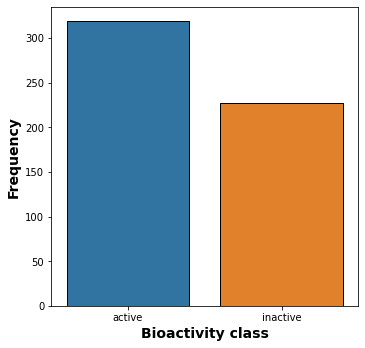

In [20]:
plt.figure(figsize=(5.5, 5.5))

sns.countplot(x='bioactivity_class', data=df, edgecolor='black')

plt.xlabel('Bioactivity class', fontsize=14, fontweight='bold')
plt.ylabel('Frequency', fontsize=14, fontweight='bold')
plt.savefig('CZsbioactivityclass.png')

#### **Lipinski descriptors**

In [66]:
def lipinski(smiles, verbose=False):

    moldata= []
    for elem in smiles:
        mol=Chem.MolFromSmiles(elem) 
        moldata.append(mol)
       
    baseData= np.arange(1,1)
    i=0  
    for mol in moldata:        
       
        desc_MolWt = Descriptors.MolWt(mol)
        desc_MolLogP = Descriptors.MolLogP(mol)
        desc_NumHDonors = Lipinski.NumHDonors(mol)
        desc_NumHAcceptors = Lipinski.NumHAcceptors(mol)
           
        row = np.array([desc_MolWt,
                        desc_MolLogP,
                        desc_NumHDonors,
                        desc_NumHAcceptors])   
    
        if(i==0):
            baseData=row
        else:
            baseData=np.vstack([baseData, row])
        i=i+1      
    
    columnNames=["MW","LogP","NumHDonors","NumHAcceptors"]   
    descriptors = pd.DataFrame(data=baseData,columns=columnNames)
    
    return descriptors

In [67]:
df_lipinski = lipinski(df.canonical_smiles)

In [68]:
df_lipinski.head()

,MW,LogP,NumHDonors,NumHAcceptors
0,262.165,2.9619,2.0,2.0
1,211.652,1.7323,2.0,2.0
2,300.225,3.0684,2.0,2.0
3,394.725,4.9093,1.0,2.0
4,288.214,2.6493,3.0,2.0


#### **Continuous descriptors**

In [21]:
#All descriptors available in rdkit
descriptors_list = [x[0] for x in Descriptors._descList]
print(descriptors_list, len(descriptors_list))

['MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex', 'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt', 'ExactMolWt', 'NumValenceElectrons', 'NumRadicalElectrons', 'MaxPartialCharge', 'MinPartialCharge', 'MaxAbsPartialCharge', 'MinAbsPartialCharge', 'FpDensityMorgan1', 'FpDensityMorgan2', 'FpDensityMorgan3', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n', 'Chi2v', 'Chi3n', 'Chi3v', 'Chi4n', 'Chi4v', 'HallKierAlpha', 'Ipc', 'Kappa1', 'Kappa2', 'Kappa3', 'LabuteASA', 'PEOE_VSA1', 'PEOE_VSA10', 'PEOE_VSA11', 'PEOE_VSA12', 'PEOE_VSA13', 'PEOE_VSA14', 'PEOE_VSA2', 'PEOE_VSA3', 'PEOE_VSA4', 'PEOE_VSA5', 'PEOE_VSA6', 'PEOE_VSA7', 'PEOE_VSA8', 'PEOE_VSA9', 'SMR_VSA1', 'SMR_VSA10', 'SMR_VSA2', 'SMR_VSA3', 'SMR_VSA4', 'SMR_VSA5', 'SMR_VSA6', 'SMR_VSA7', 'SMR_VSA8', 'SMR_VSA9', 'SlogP_VSA1', 'SlogP_VSA10', 'SlogP_VSA11', 'SlogP_VSA12', 'SlogP_VSA2', 'SlogP_VSA3', 'SlogP_VSA4', 'SlogP_VSA5', 'SlogP_VSA6', 'SlogP_VSA7', 'SlogP_VSA8', 'SlogP_VSA9', 'TPSA'

In [22]:
molecules = [Chem.MolFromSmiles(mol) for mol in df.canonical_smiles]

In [23]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator([desc[0] for desc in Descriptors.descList])
X = pd.DataFrame([list(calculator.CalcDescriptors(mol)) for mol in molecules],
                     index=df.index,
                     columns=list(calculator.GetDescriptorNames()))

In [24]:
X.head()

,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,5.858062,0.105936,5.858062,0.105936,0.365862,262.165,253.093,260.989424,80,0,...,0,0,0,0,0,0,0,0,0,0
1,10.379971,-0.688539,10.379971,0.621412,0.567909,211.652,201.572,211.051240,74,0,...,0,0,0,0,0,0,0,0,0,1
2,4.169213,0.500877,4.169213,0.500877,0.382652,300.225,286.113,299.009181,86,0,...,0,0,0,0,0,0,0,0,0,0
3,5.977119,0.576170,5.977119,0.576170,0.733473,394.725,381.621,392.970208,112,0,...,0,0,0,0,0,0,0,0,0,0
4,5.345821,0.160370,5.345821,0.160370,0.345142,288.214,274.102,287.009181,82,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
X.shape

(546, 200)

In [26]:
df2D = pd.concat([df, X], axis=1)

In [27]:
df2D.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value_norm,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,...,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,50.0,5.858062,0.105936,5.858062,0.105936,0.365862,262.165,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,10000.0,10.379971,-0.688539,10.379971,0.621412,0.567909,211.652,...,0,0,0,0,0,0,0,0,0,1
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,10000.0,4.169213,0.500877,4.169213,0.500877,0.382652,300.225,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,1000.0,5.977119,0.576170,5.977119,0.576170,0.733473,394.725,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,10000.0,5.345821,0.160370,5.345821,0.160370,0.345142,288.214,...,0,0,0,0,0,0,0,0,0,0


In [28]:
def pIC50(input):
    pIC50 = []

    for i in input['standard_value_norm']:
        molar = i*(10**-9) # Converts nM to M
        pIC50.append(-np.log10(molar))

    input['pIC50'] = pIC50
    x = input.drop('standard_value_norm', 1)
        
    return x

In [29]:
df2D_final = pIC50(df2D)

In [30]:
df2D_final.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pIC50
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,5.858062,0.105936,5.858062,0.105936,0.365862,262.165,253.093,...,0,0,0,0,0,0,0,0,0,7.30103
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,10.379971,-0.688539,10.379971,0.621412,0.567909,211.652,201.572,...,0,0,0,0,0,0,0,0,1,5.00000
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,4.169213,0.500877,4.169213,0.500877,0.382652,300.225,286.113,...,0,0,0,0,0,0,0,0,0,5.00000
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,5.977119,0.576170,5.977119,0.576170,0.733473,394.725,381.621,...,0,0,0,0,0,0,0,0,0,6.00000
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,5.345821,0.160370,5.345821,0.160370,0.345142,288.214,274.102,...,0,0,0,0,0,0,0,0,0,5.00000


In [58]:
df2D_final.columns

Index(['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class',
       'MaxEStateIndex', 'MinEStateIndex', 'MaxAbsEStateIndex',
       'MinAbsEStateIndex', 'qed', 'MolWt', 'HeavyAtomMolWt',
       ...
       'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene', 'fr_tetrazole',
       'fr_thiazole', 'fr_thiocyan', 'fr_thiophene', 'fr_unbrch_alkane',
       'fr_urea', 'pIC50'],
      dtype='object', length=204)

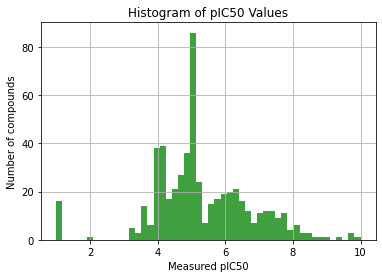

In [31]:
plt.hist(df2D_final.pIC50, 50, facecolor='green', alpha=0.75)
plt.xlabel('Measured pIC50')
plt.ylabel('Number of compounds')
plt.title(r'Histogram of pIC50 Values')
plt.grid(True)
plt.savefig('histogrampIC50.png')
plt.show()

In [32]:
df2D_final.pIC50.mean()

5.292947052843078

In [72]:
df_lipinski2 = pd.concat([df_lipinski, df], axis=1)

In [73]:
df_lipinski2.head()

,MW,LogP,NumHDonors,NumHAcceptors,molecule_chembl_id,canonical_smiles,bioactivity_class,standard_value_norm
0,262.165,2.9619,2.0,2.0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,50.0
1,211.652,1.7323,2.0,2.0,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,10000.0
2,300.225,3.0684,2.0,2.0,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,10000.0
3,394.725,4.9093,1.0,2.0,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,1000.0
4,288.214,2.6493,3.0,2.0,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,10000.0


In [75]:
dflipinski_final = pIC50(df_lipinski2)
dflipinski_final.head()

,MW,LogP,NumHDonors,NumHAcceptors,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50
0,262.165,2.9619,2.0,2.0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,7.30103
1,211.652,1.7323,2.0,2.0,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,5.00000
2,300.225,3.0684,2.0,2.0,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,5.00000
3,394.725,4.9093,1.0,2.0,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,6.00000
4,288.214,2.6493,3.0,2.0,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,5.00000


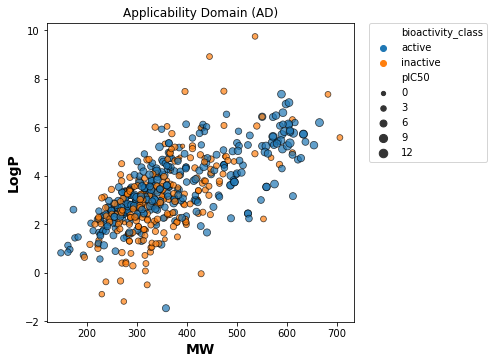

In [79]:
plt.figure(figsize=(5.5, 5.5))

sns.scatterplot(x='MW', y='LogP', data=dflipinski_final, hue='bioactivity_class', size='pIC50', edgecolor='black', alpha=0.7)

plt.xlabel('MW', fontsize=14, fontweight='bold')
plt.ylabel('LogP', fontsize=14, fontweight='bold')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0)
plt.title('Applicability Domain (AD)')
plt.savefig('LogPvsMW.png', bbox_inches='tight', pad_inches=0.1)

In [33]:
df2D_final.to_csv('CZP_bioactivity_preprocessed_data_RDKit_2D.csv', index=False)

#### **Binary descriptors: RDKit Morgan Fingerprint**

In [34]:
smiles_list = df['canonical_smiles'].tolist()
mols = []

In [35]:
for molecule in smiles_list:
    m = Chem.MolFromSmiles(molecule) # Lee SMILES
    mols.append(m)

In [36]:
len(mols)

546

In [37]:
# generate binary Morgan fingerprint with radius 2 ECFP4-like
data2 = []

for mol in molecules:
    ecfp4 = [int(x) for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024)]
    data2.append(ecfp4)

ecfp4_df = pd.DataFrame(data2, index=df.index)

In [38]:
# generate binary Morgan fingerprint with radius 3 ECFP6-like
data3 = []

for mol in molecules:
    ecfp6 = [int(x) for x in AllChem.GetMorganFingerprintAsBitVect(mol, 3, 1024)]
    data3.append(ecfp6)

ecfp6_df = pd.DataFrame(data3, index=df.index)

In [39]:
#FCFP6
data4 = []

for mol in molecules:
    fcfp6 = [int(x) for x in AllChem.GetMorganFingerprintAsBitVect(mol, 3, 1024, useFeatures=True)]
    data4.append(fcfp6)

fcfp6_df = pd.DataFrame(data4, index=df.index)

In [40]:
#FCFP4
data5 = []

for mol in molecules:
    fcfp4 = [int(x) for x in AllChem.GetMorganFingerprintAsBitVect(mol, 2, 1024, useFeatures=True)]
    data5.append(fcfp4)

fcfp4_df = pd.DataFrame(data5, index=df.index)

In [41]:
df2D_final.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,...,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea,pIC50
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,5.858062,0.105936,5.858062,0.105936,0.365862,262.165,253.093,...,0,0,0,0,0,0,0,0,0,7.30103
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,10.379971,-0.688539,10.379971,0.621412,0.567909,211.652,201.572,...,0,0,0,0,0,0,0,0,1,5.00000
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,4.169213,0.500877,4.169213,0.500877,0.382652,300.225,286.113,...,0,0,0,0,0,0,0,0,0,5.00000
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,5.977119,0.576170,5.977119,0.576170,0.733473,394.725,381.621,...,0,0,0,0,0,0,0,0,0,6.00000
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,5.345821,0.160370,5.345821,0.160370,0.345142,288.214,274.102,...,0,0,0,0,0,0,0,0,0,5.00000


In [42]:
seleccion = df2D_final[['molecule_chembl_id', 'canonical_smiles', 'bioactivity_class', 'pIC50']]

In [43]:
#Concatenar smiles, chemblid, pIC50
ecfp4_df2 = pd.concat([seleccion, ecfp4_df], axis=1) 
ecfp6_df2 = pd.concat([seleccion, ecfp6_df], axis=1)
fcfp6_df2 = pd.concat([seleccion, fcfp6_df], axis=1)
fcfp4_df2 = pd.concat([seleccion, fcfp4_df], axis=1)

In [44]:
ecfp4_df2.to_csv('CZP_ecfp4.csv', index=False)

In [45]:
ecfp6_df2.to_csv('CZP_ecfp6.csv', index=False)

In [46]:
fcfp6_df2.to_csv('CZP_fcfp6.csv', index=False)

In [47]:
fcfp4_df2.to_csv('CZP_fcfp4.csv', index=False)

### MACCS keys

In [48]:
maccs_list = []

for mol in mols:
    maccs = [int(x) for x in MACCSkeys.GenMACCSKeys(mol)]
    maccs_list.append(maccs)

maccs = pd.DataFrame(maccs_list)

In [49]:
maccs.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
1,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,1,1,0
2,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,1,1,1,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,1,0,1,1,1,1,0,1,0


In [50]:
maccs2 = pd.concat([seleccion, maccs], axis=1)
maccs2.to_csv('CZP_maccs.csv', index=False)

## Mol2vec fingerprints

In [51]:
from gensim.models import word2vec

In [52]:
from mol2vec import features
from mol2vec import helpers

#### Padel Descriptors

In [53]:
padel = pd.read_csv('padel_descriptors_inhibidoresCZP.csv')

In [54]:
padel.head()

,Name,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,PubchemFP6,PubchemFP7,PubchemFP8,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL90512,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL327902,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL88307,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL88354,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL90371,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [55]:
padel.drop('Name', axis=1, inplace=True)

In [56]:
padel_final = pd.concat([seleccion, padel], axis=1)
padel_final.to_csv('CZP_padeldesc.csv', index=False)

In [57]:
padel_final.head()

,molecule_chembl_id,canonical_smiles,bioactivity_class,pIC50,PubchemFP0,PubchemFP1,PubchemFP2,PubchemFP3,PubchemFP4,PubchemFP5,...,PubchemFP871,PubchemFP872,PubchemFP873,PubchemFP874,PubchemFP875,PubchemFP876,PubchemFP877,PubchemFP878,PubchemFP879,PubchemFP880
0,CHEMBL90512,C/C(=N\N=C(\N)S)c1ccc(Cl)c(Cl)c1,active,7.30103,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CHEMBL327902,C/C(=N\NC(N)=O)c1cccc(Cl)c1,active,5.00000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,CHEMBL88307,CC/C(=N\N=C(/S)NC)c1cccc(Br)c1,active,5.00000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CHEMBL90475,S=C(Nc1cccc(Cl)c1)N1CCC(c2cccc(Br)c2)=N1,active,6.00000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CHEMBL90371,CCC(N/N=C(/N)S)c1cccc(Br)c1,active,5.00000,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### RDKit 3D Descriptors

In [3]:
molecules = [Chem.MolFromSmiles(mol) for mol in df.canonical_smiles]

In [25]:
counter1 = 0
#name_list = []
for molecule in df.canonical_smiles:
    m = Chem.MolFromSmiles(molecule) # Lee SMILES
    m3d = Chem.AddHs(m) # Agrega los H
    props = AllChem.ETKDG() # Método que busca conformaciones? Algunos no lo usan...???
    props.pruneRmsThresh = 2.0 # ??
    props.useRandomCoords = True # Bueno para moleculas grandes??
    props.numThreads = 0 # Uso de los Threds totales de la PC
    confs = AllChem.EmbedMultipleConfs(m3d,100,props) # Que diferencia hay con ETKDG? 
    ps = AllChem.MMFFGetMoleculeProperties(m3d) # Calcula el campo de fuerza?
    print('Molecule:', counter1, 'Number of conformers:', len(confs))
    
    

    for conf in confs:
        #filename = name_list[counter1] + '-conformer-' + str(conf) + '.pdb'
        ff = AllChem.MMFFGetMoleculeForceField(m3d,ps,confId=conf) # Ver acá cada argumento
        ff.Minimize()
        AllChem.MMFFOptimizeMoleculeConfs(m3d, maxIters=10) # Diferencia con el anterior?
        energy_value = ff.CalcEnergy()
        print('Molecule-'+ str(counter1) + '-conformer-' + str(conf) + ':  ' + str(energy_value) + '\n')
        

        if conf == 0:
            energy = energy_value
        if energy_value <= energy:
            menor = conf
            energy = energy_value
        if conf == menor:
            asp = Chem.Descriptors3D.Asphericity(m, confID=conf)
            print(asp)

    counter1 += 1
    

Molecule: 0 Number of conformers: 1
Molecule-0-conformer-0:  5.25573734314702



ArgumentError: Python argument types in
    rdkit.Chem.rdMolDescriptors.CalcAsphericity(Mol)
did not match C++ signature:
    CalcAsphericity(RDKit::ROMol mol, int confId=-1, bool useAtomicMasses=True, bool force=True)

In [26]:
def rdkit_descriptors_3d(mols):
    from rdkit.Chem.rdMolDescriptors import (
        CalcSpherocityIndex,
        CalcAsphericity,
        CalcEccentricity,
        CalcInertialShapeFactor,
        CalcRadiusOfGyration,
        CalcNPR1,
        CalcNPR2,
        CalcPMI1,
        CalcPMI2,
        CalcPMI3,
        CalcPBF,
    )
    fdesc = [CalcSpherocityIndex, CalcAsphericity, CalcEccentricity, CalcInertialShapeFactor, CalcRadiusOfGyration, CalcNPR1, CalcNPR2, CalcPMI1, CalcPMI2, CalcPMI3, CalcPBF]
    header = np.array(['SpherocityIndex', 'Asphericity', 'Eccentricity', 'InertialShapeFactor', 'RadiusOfGyration', 'NPR1', 'NPR2', 'PMI1', 'PMI2', 'PMI3', 'PBF'], dtype=np.str)
    result = np.empty((len(mols), len(fdesc)), dtype=np.float32)
    for i, m in enumerate(tqdm.tqdm(mols)):
        if m.GetNumConformers() == 1:
            for j in range(len(fdesc)):
                result[i,j] = fdesc[j](m)
        elif m.GetNumConformers() == 0:
            result[i] = np.nan
        else:
            raise ValueError("every molecule must have at most 1 conformer")
    return result, header

In [33]:
df.canonical_smiles.isna().sum()

0

In [34]:
smiles_list = df.canonical_smiles.to_list()
for molecule in smiles_list:
    m = Chem.MolFromSmiles(molecule) # Lee SMILES
    m3d = Chem.AddHs(m) # Agrega los H
    props = AllChem.ETKDG() # Método que busca conformaciones? Algunos no lo usan...???
    props.pruneRmsThresh = 2.0 # ??
    props.useRandomCoords = True # Bueno para moleculas grandes??
    props.numThreads = 0 # Uso de los Threds totales de la PC
    confs = AllChem.EmbedMultipleConfs(m3d,100,props) # Que diferencia hay con ETKDG? 
    ps = AllChem.MMFFGetMoleculeProperties(m3d) # Calcula el campo de fuerza?
    
        for conf in confs:
            ff = AllChem.MMFFGetMoleculeForceField(m3d,ps,confId=conf)
            

KeyboardInterrupt: 